# WP1 - Anomaly subgraph extraction: Finding anomalies

In [5]:
import py2neo
import pandas as pd
import numpy as np
from spot import bidSPOT, dSPOT,  SPOT

In [3]:
# TODO: remove before upload
graph = py2neo.Graph("bolt://192.168.1.185:7687", auth=("neo4j", ""))

In [20]:
full_data = pd.read_csv('../data/loadtest-Updated.csv').sort_values(by=['Time', 'Unnamed: 0'])

# Prepare data
u_data = (full_data['Time'] == '2/17/2022')| (full_data['Time'] == '3/2/2022')
all_data = full_data[u_data]
# initial batch
u_init_data = (full_data['Time'] == '10/14/2021') | (full_data['Time'] == '10/20/2021')| (full_data['Time'] == '10/19/2021')
all_init_data = full_data[u_init_data]

csv_nodes = full_data.columns.drop(['Time', 'Unnamed: 0'])
print("Node names from data csv: ", sorted(csv_nodes))
graph_nodes = [node['id'] for node in graph.nodes.match().all()]
print("Node names from graph: ", sorted(graph_nodes))
print("Nodes in graph but not in data csv: ", sorted(set(graph_nodes) - set(csv_nodes)))
print("Nodes in data csv but not in graph: ", sorted(set(csv_nodes) - set(graph_nodes)))
for column_name in csv_nodes:
    init_data = all_init_data[column_name].to_numpy()
    data = all_data[column_name].to_numpy()

    q = 1e-5  			# risk parameter
    s = SPOT(q)  		# SPOT object
    s.fit(init_data,data) 	# data import
    s.initialize(verbose=False) 		# initialization step
    results = s.run() 	# run
    #s.plot(results) 	# plot
    alarms = results["alarms"]
    print(column_name)
    if len(alarms) > 0:
        print("had an anomaly")


Node names from data csv:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db']
Node names from graph:  ['carts', 'carts-db', 'catalogue', 'catalogue-db', 'front-end', 'master', 'orders', 'orders-db', 'payment', 'queue-master', 'rabbitmq', 'session-db', 'shipping', 'user', 'user-db', 'worker1', 'worker2']
Nodes in graph but not in data csv:  ['master', 'worker1', 'worker2']
Nodes in data csv but not in graph:  []


100%|██████████| 589/589 [00:01<00:00, 467.89it/s]


carts
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 657.27it/s]


carts-db
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 3809.99it/s]


catalogue


100%|██████████| 589/589 [00:00<00:00, 9842.96it/s]


catalogue-db
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 735.38it/s] 


front-end
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 712.79it/s]


orders
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 916.25it/s] 


orders-db
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 1736.98it/s]


payment
had an anomaly


100%|██████████| 589/589 [00:01<00:00, 346.41it/s]


queue-master
had an anomaly


100%|██████████| 589/589 [00:02<00:00, 224.30it/s]


rabbitmq
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 14226.58it/s]


session-db
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 2559.99it/s]


shipping
had an anomaly


100%|██████████| 589/589 [00:00<00:00, 2343.58it/s]
c:\Users\Andrea1\Documents\HPI\MLGraphs\Spatio-Temporal-Graphs\src\spot.py:238: RuntimeWarning: invalid value encountered in double_scalars
  X0 = np.arange(bounds[0]+step,bounds[1],step)


user


ValueError: arange: cannot compute length

['carts',
 'user',
 'user-db',
 'catalogue',
 'catalogue-db',
 'orders-db',
 'carts-db',
 'queue-master',
 'rabbitmq',
 'session-db',
 'master',
 'worker1',
 'worker2',
 'front-end',
 'orders',
 'shipping',
 'payment']

Initial threshold : 0.0115
Number of peaks : 4
Grimshaw maximum log-likelihood estimation ... [done]
	γ = -0.29489623181763014
	σ = 0.0008983580938078887
	L = 25.23935213122546
Extreme quantile (probability = 1e-05): 0.014211516462822898


100%|██████████| 589/589 [00:00<00:00, 784.54it/s] 


had an anomaly


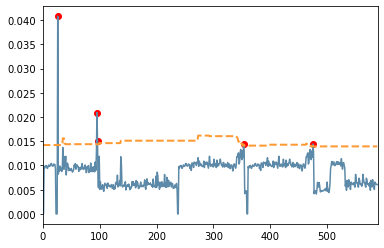

In [9]:
f = '../data/loadtest-Updated.csv'
P = pd.read_csv(f)
# stream
u_data = (P['Time'] == '2/17/2022')| (P['Time'] == '3/2/2022')
data = P['orders-db'][u_data].values
# initial batch
u_init_data = (P['Time'] == '10/14/2021') | (P['Time'] == '10/20/2021')| (P['Time'] == '10/19/2021')
init_data = P['orders-db'][u_init_data].values
q = 1e-5  			# risk parameter
s = SPOT(q)  		# SPOT object
s.fit(init_data,data) 	# data import
s.initialize() 		# initialization step
results = s.run() 	# run
s.plot(results) 	# plot
alarms = results["alarms"]
if len(alarms) > 0:
    print("had an anomaly")
